# Words and Their Co-occurences

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

from vdata import Voynich, Folio
a = Voynich()

In [32]:
lines = list(a.data[a.data.words <= 4].text)
words = ' '.join(text).split()
print(len(lines), 'lines')
print(len(words), 'words')

1493 lines
34991 words


Don't worry, we still have most of them

In [33]:
lines = list(a.data[a.data.words > 4].text)
words = ' '.join(lines).split()
print(len(lines), 'lines')
print(len(words), 'words')

3721 lines
34991 words


In [34]:
lines[:10]

['fachys ykal ar ataiin shol shory cthres y kor sholdy',
 'sory ckhar or y kair chtaiin shar are cthar cthar dan',
 'syaiir sheky or ykaiin shod cthoary cthes daraiin sa',
 'ooiin oteey oteos roloty cthar daiin otaiin or okan',
 'dair y chear cthaiin cphar cfhaiin',
 'odar o y shol cphoy oydar sh s cfhoaiin shodary',
 'yshey shody okchoy otchol chocthy oschy dain chor kos',
 'ydain cphesaiin ol s cphey ytain shoshy cphodales',
 'oksho kshoy otairin oteol okan shodain sckhey daiin',
 'shoy ckhey kodaiin cphy cphodaiils cthey she oldain d']

# Bigram co-occurences

In [65]:
def build_ngram_dict(text, n=3):
    trigrams = [text[i:i+n] for i in range(len(text) - n)]
    trigrams = list(set(trigrams))
    t2i = {x:i for i,x in enumerate(trigrams)}
    i2t = {x:i for i,x in t2i.items()}
    return t2i, i2t

In [115]:
text = ' '.join(lines)
text = text

In [217]:
from collections import deque

t2i, i2t = build_ngram_dict(text, n=2)
n = len(t2i.keys())

print('building a {} by {} matrix...'.format(n,n))

# build co_occurence matrix
co_occurences = np.zeros((n,n))

# run through the text
d = deque(maxlen=20)
for i in range(len(text) - 2):
    chars = text[i:i+2]
    for i in d:
        a_int = t2i[chars]
        b_int = t2i[i]
        co_occurences[a_int, b_int] += 1
    
    d.append(chars)
print('done')

building a 324 by 324 matrix...
done


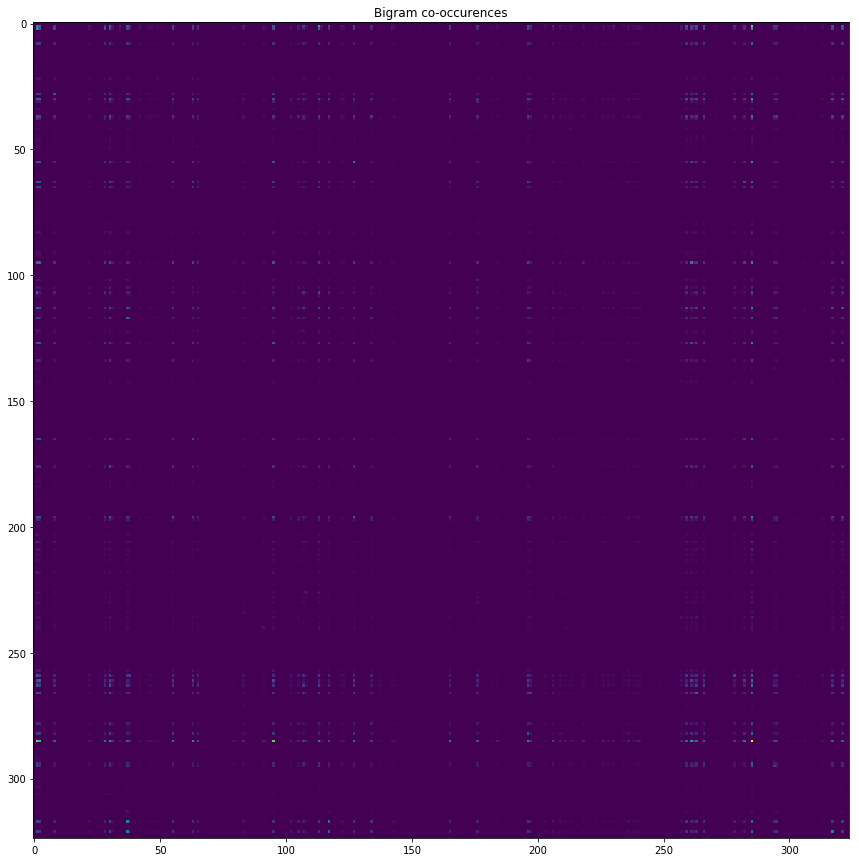

In [225]:
# visualize the result
plt.figure(figsize=(15,15))
plt.title('Bigram co-occurences')
_ = plt.imshow(co_occurences)

We want to filter out all the background and only get the high-frequency co-occurences

[  1   2   8  28  30  37  38  55  63  65  95 107 113 117 127 134 165 176
 196 197 259 261 263 266 278 282 285 294 295 317 321]


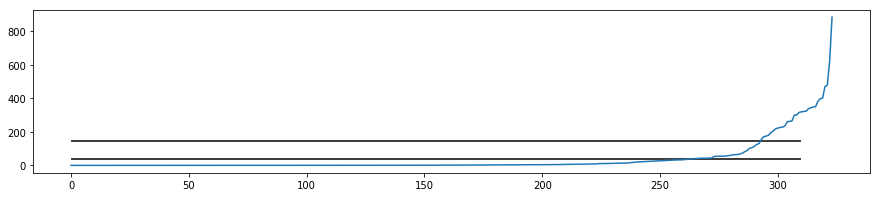

In [211]:
va = np.mean(co_occurences, axis=0)
mean, sd = np.mean(va), np.std(va)
va_good = np.where(va > mean + sd)
indices = va_good[0]
print(indices)

plt.figure(figsize=(15, 3))
plt.plot(sorted(va))
plt.hlines([mean, mean+sd], 0, 310)

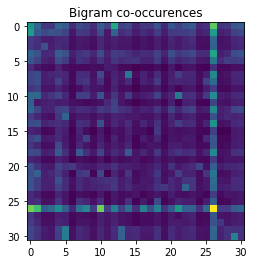

In [219]:
new_stuff = co_occurences[indices, :][:,indices]

# visualize the result
# plt.figure(figsize=(15,15))
plt.title('Bigram co-occurences')
_ = plt.imshow(new_stuff)

In [220]:
# the bigrams that these correspond to
[i2t[x] for x in indices]

['ch',
 'he',
 ' s',
 'sh',
 ' o',
 'ai',
 'or',
 'qo',
 'ee',
 'eo',
 'dy',
 'ho',
 ' c',
 'ii',
 ' q',
 'ka',
 'ey',
 'ot',
 'ok',
 'al',
 'r ',
 'ed',
 'ol',
 'l ',
 'ar',
 'ke',
 'y ',
 ' d',
 'da',
 'in',
 'n ']

## What does it mean for certain bigrams/letters to be frequently co-located?

Imagine if we had a language where every letter got multipled 5 tttttiiiiimmmmmeeeeesssss. If we were to look at how much more information this contains than the base language, the answer should be 0 (!), because each group of letters contributes no information that the first letter in the group gave!

If we think about the s's as distinct, $s_1s_2$ would appear next to $s_2s_3$ 100% of the time; each letter group would co-occur a lot. This would be the case even if we shuffled the data: tttittmiimeesssee.

One way to think about this is in terms of predictability. 

What is the length of words here?

In [236]:
len(list(udhr.words('English-Latin1')))

1781

In [260]:
from nltk.corpus import europarl_raw
from itertools import islice

finnish = europarl_raw.finnish.words()
for t in nltk.bigrams(islice(finnish, 10)):
    print(t)

('Istuntokauden', 'uudelleenavaaminen')
('uudelleenavaaminen', 'Julistan')
('Julistan', 'perjantaina')
('perjantaina', 'joulukuun')
('joulukuun', '17.')
('17.', 'päivänä')
('päivänä', 'keskeytetyn')
('keskeytetyn', 'Euroopan')
('Euroopan', 'parlamentin')


 dir(europarl_raw)

 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'italian',
 'portuguese',
 'spanish',

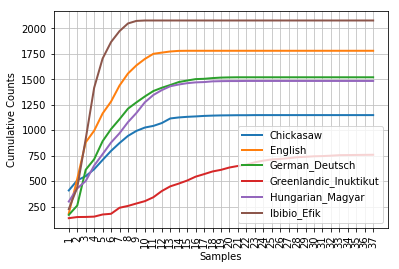

In [231]:
import nltk
# # nltk.download('udhr')
# nltk.download('europarl_raw')

from nltk.corpus import udhr
languages = ['Chickasaw', 'English', 'German_Deutsch',
             'Greenlandic_Inuktikut', 'Hungarian_Magyar', 'Ibibio_Efik']
cfd = nltk.ConditionalFreqDist(
    (lang, len(word))
    for lang in languages
    for word in udhr.words(lang + '-Latin1'))

cfd.plot(cumulative=True)

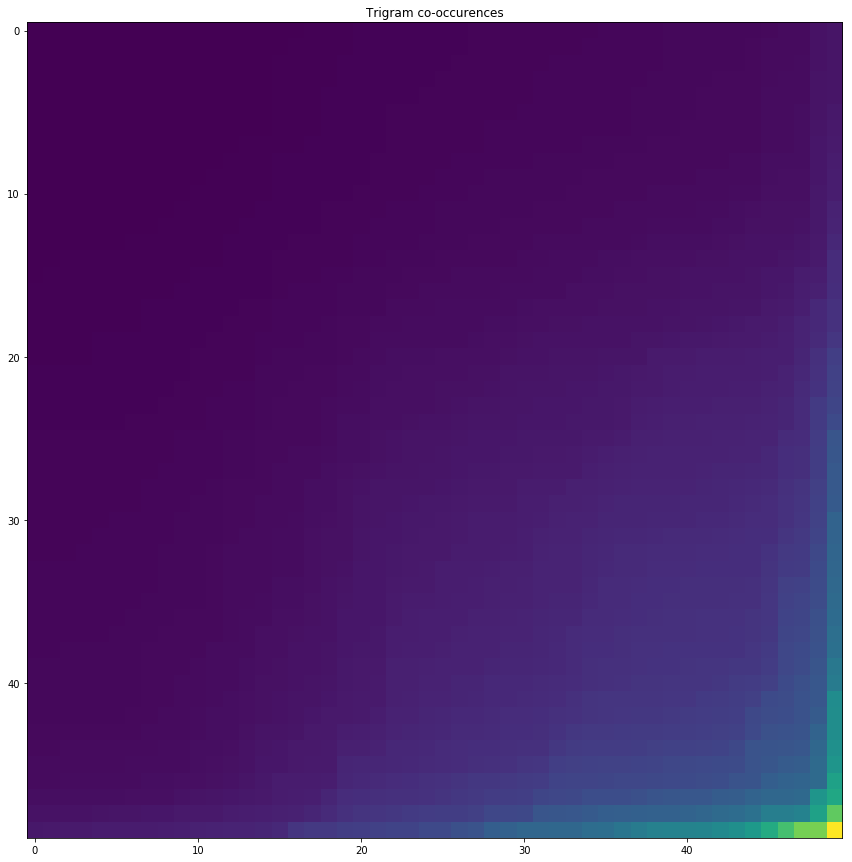

In [213]:
# we could also sort 
co_occurences.sort(0)
co_occurences.sort(1)

# visualize the result
plt.figure(figsize=(15,15))
plt.title('Trigram co-occurences')
_ = plt.imshow(co_occurences[-50:, -50:])

In [94]:
co_occurences[-50:, -50:]

array([[  2.,   2.,   2., ...,  19.,  23.,  31.],
       [  2.,   2.,   2., ...,  19.,  23.,  32.],
       [  2.,   2.,   2., ...,  19.,  23.,  32.],
       ...,
       [ 11.,  11.,  12., ..., 105., 131., 248.],
       [ 14.,  14.,  14., ..., 130., 141., 282.],
       [ 15.,  15.,  16., ..., 153., 251., 294.]])